In [325]:

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

RANDOM_SEED = 42
CV_FOLDS = 5
N_ITER_TUNING = 50

In [326]:
# Load dataset and filter for wildfire-exposed regions with complete data
df = pd.read_csv("xgboost_data.csv")


In [327]:
# Adding features

# Rolling averages (commenting them out cause we lose to much data)
# Rolling average of price change over the last 1 year (excluding current)
df["ROLLING_1yr_PRICE_CHANGE"] = df.groupby("ZipCode")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(1).mean()
# Rolling average of price change over the last 2 years (excluding current): Smooths short-term volatility to identify trends
#df["ROLLING_2yr_PRICE_CHANGE"] = df.groupby("ZipCode")["PCT_PRICE_CHANGE (%)"].shift(1).rolling(2).mean() we lose too much data

# Lag price-related features
df['HOME_PRICE_LAG1'] = df.groupby('ZipCode')['HOME_PRICE'].shift(1)
df['PRICE_CHANGE_LAG1'] = df.groupby('ZipCode')['PRICE_CHANGE'].shift(1)
df['PRICE_CHANGE_DIFF'] = df['PRICE_CHANGE'] - df['PRICE_CHANGE_LAG1']

# What it is: Max % of ZIP burned from the previous year.
# Why: Fires may have a lagged effect on market prices — impact might show up the year after.
df['PREV_MAX_PCT_ZIP_BURNED'] = df.groupby('ZipCode')['MAX_PCT_ZIP_BURNED'].shift(1)

# Post-fire year: fire happened in the previous year
df['FIRE_LAST_YEAR'] = df.groupby('ZipCode')['ANY_MAJOR_FIRE'].shift(1).fillna(0).astype(int)


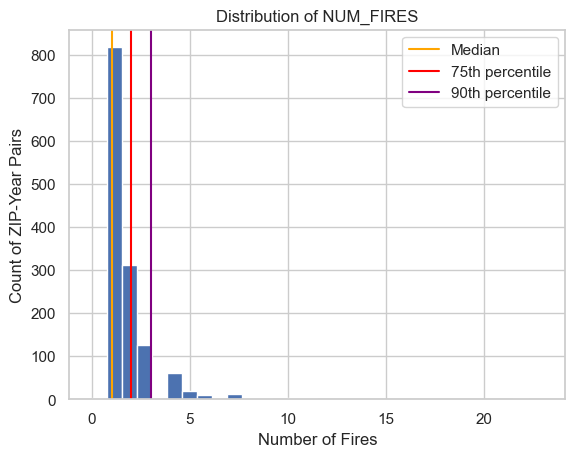

In [328]:
# Creating Fire Shock feature

# import matplotlib.pyplot as plt

# Helps us understand what can be classified as a shock in terms of number of fires
plt.hist(df['NUM_FIRES'], bins=30)
plt.axvline(df['NUM_FIRES'].median(), color='orange', label='Median')
plt.axvline(df['NUM_FIRES'].quantile(0.75), color='red', label='75th percentile')
plt.axvline(df['NUM_FIRES'].quantile(0.9), color='purple', label='90th percentile')
plt.legend()
plt.xlabel('Number of Fires')
plt.ylabel('Count of ZIP-Year Pairs')
plt.title('Distribution of NUM_FIRES')
plt.show()


# Fire shock indicator: 1 if ZIP had 2+ fires in a year (unusually high fire activity).
# Based on domain logic and histogram — most ZIP-years have 0–1 fire, so 2+ is a meaningful threshold.
df['FIRE_SHOCK'] = (df['NUM_FIRES'] >= 2).astype(int)

# drop Unnamed column
df = df.drop(columns=["Unnamed: 0"])

# Reset index for modeling
df.reset_index(drop=True, inplace=True)


In [329]:
#  Replace wildfire NAs with meaningful values: replace it with 0 cause it simply never happened

# Define fire-related columns where NaN should be treated as 0 (no exposure)
fire_cols = [
    'NUM_FIRES',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_LAST_YEAR',
    'PREV_MAX_PCT_ZIP_BURNED' 
]

# Replace NaNs with 0 for those columns
df[fire_cols] = df[fire_cols].fillna(0)

df.head


<bound method NDFrame.head of        ZipCode  YEAR  RegionID             City  \
0        90001  2012     95982  Florence-Graham   
1        90001  2013     95982  Florence-Graham   
2        90001  2014     95982  Florence-Graham   
3        90001  2015     95982  Florence-Graham   
4        90001  2016     95982  Florence-Graham   
...        ...   ...       ...              ...   
10125    96161  2014     98672          Truckee   
10126    96161  2015     98672          Truckee   
10127    96161  2016     98672          Truckee   
10128    96161  2017     98672          Truckee   
10129    96161  2018     98672          Truckee   

                                    Metro          CountyName     HOME_PRICE  \
0      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  173120.150950   
1      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  213862.137082   
2      Los Angeles-Long Beach-Anaheim, CA  Los Angeles County  250721.453550   
3      Los Angeles-Long Beach-Anaheim

,PCT_PRICE_CHANGE (%),NUM_FIRES,HOME_PRICE_LAG1,FIRE_SHOCK,FIRE_LAST_YEAR
count,10130.000000,10130.000000,8.634000e+03,10130.000000,10130.000000
mean,9.397379,0.245706,5.225861e+05,0.055084,0.012734
std,8.073661,0.862752,4.556856e+05,0.228155,0.112132
min,-18.038091,0.000000,2.610063e+04,0.000000,0.000000
25%,4.461895,0.000000,2.343489e+05,0.000000,0.000000
50%,8.122122,0.000000,3.991743e+05,0.000000,0.000000
75%,13.272930,0.000000,6.439586e+05,0.000000,0.000000
max,68.321444,23.000000,5.932884e+06,1.000000,1.000000


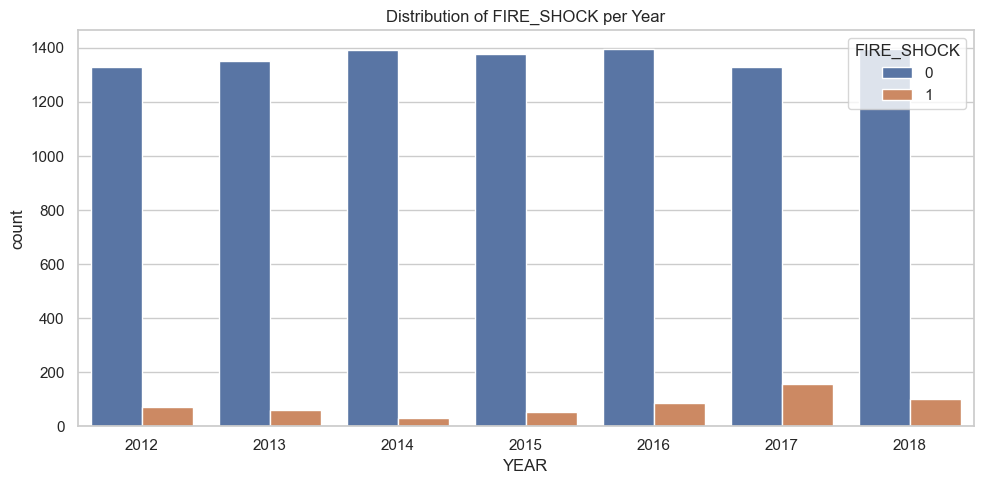

In [330]:

# Display summary statistics and fire shock distribution
display(df[['PCT_PRICE_CHANGE (%)', 'NUM_FIRES', 'HOME_PRICE_LAG1', 'FIRE_SHOCK', 'FIRE_LAST_YEAR']].describe())

# Plot fire shock over years
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='YEAR', hue='FIRE_SHOCK')
plt.title("Distribution of FIRE_SHOCK per Year")
plt.tight_layout()
plt.show()

In [331]:
df.isna().sum()

ZipCode                         0
YEAR                            0
RegionID                        0
City                          175
Metro                         461
CountyName                      0
HOME_PRICE                      0
PRICE_CHANGE                    0
PCT_PRICE_CHANGE (%)            0
NUM_FIRES                       0
TOTAL_ACRES_BURNED_IN_ZIP       0
AVG_FIRE_DURATION_DAYS          0
MAX_PCT_ZIP_BURNED              0
ANY_MAJOR_FIRE                  0
FIRE_EXPOSED                    0
ROLLING_1yr_PRICE_CHANGE     1496
HOME_PRICE_LAG1              1496
PRICE_CHANGE_LAG1            1496
PRICE_CHANGE_DIFF            1496
PREV_MAX_PCT_ZIP_BURNED         0
FIRE_LAST_YEAR                  0
FIRE_SHOCK                      0
dtype: int64

In [332]:
# Remove Na's or else linear regression below won't work

df.dropna(subset=[
    'ROLLING_1yr_PRICE_CHANGE', 
    'HOME_PRICE_LAG1', 
    'PRICE_CHANGE_LAG1', 
    'PRICE_CHANGE_DIFF'
], inplace=True)


# This is the xgboost model that answers how to predict price for zip codes exposed to fire and zip codes not exposed to fire

In [333]:
# Step 1: Predict price change using only historical price info
X_price = df[['HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1']]
y = df['PCT_PRICE_CHANGE (%)']

price_model = LinearRegression()
price_model.fit(X_price, y)
df['price_pred'] = price_model.predict(X_price)
df['residual'] = y - df['price_pred']


In [334]:

# Step 2: Use fire-related variables to predict the residual
fire_features = [
    'NUM_FIRES',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED',
    'ANY_MAJOR_FIRE',
    'FIRE_EXPOSED',
    'PREV_MAX_PCT_ZIP_BURNED',
    'FIRE_LAST_YEAR',
    'FIRE_SHOCK',   
]

X_resid = df[fire_features]
y_resid = df['residual']

# Train XGBoost on residuals
tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED)

param_dist = {
    'n_estimators': randint(100, 800),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_lambda': uniform(0.5, 2.0),
    'reg_alpha': uniform(0, 1.0)
}

search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=N_ITER_TUNING, scoring='r2', cv=tscv,
    random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
search.fit(X_resid, y_resid)
best_model = search.best_estimator_
df['resid_pred'] = best_model.predict(X_resid)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


Combined Model Evaluation:
RMSE: 6.5206
MAE : 4.6774
R²  : 0.0578


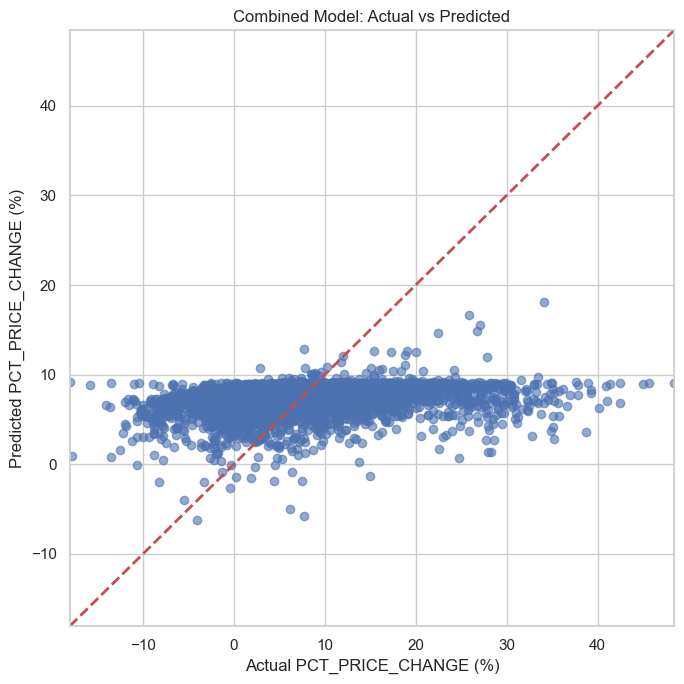

In [335]:

# Final prediction = historical price model + residual prediction
df['final_pred'] = df['price_pred'] + df['resid_pred']

# Evaluate final model
rmse = np.sqrt(mean_squared_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred']))
mae = mean_absolute_error(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])
r2 = r2_score(df['PCT_PRICE_CHANGE (%)'], df['final_pred'])

print("Combined Model Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

# Scatter plot of predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(df['PCT_PRICE_CHANGE (%)'], df['final_pred'], alpha=0.6)
min_v = min(df['PCT_PRICE_CHANGE (%)'].min(), df['final_pred'].min())
max_v = max(df['PCT_PRICE_CHANGE (%)'].max(), df['final_pred'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=2)
plt.xlabel("Actual PCT_PRICE_CHANGE (%)")
plt.ylabel("Predicted PCT_PRICE_CHANGE (%)")
plt.title("Combined Model: Actual vs Predicted")
plt.grid(True)
plt.xlim(min_v, max_v)
plt.ylim(min_v, max_v)
plt.tight_layout()
plt.show()

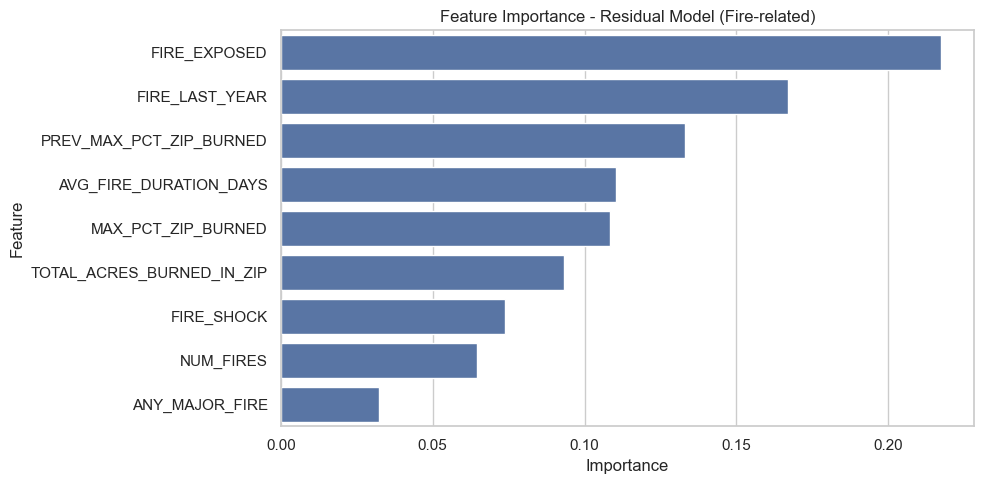

In [336]:

# Show feature importance from XGBoost residual model
importances = best_model.feature_importances_
fi = pd.DataFrame({'Feature': fire_features, 'Importance': importances})
fi = fi.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=fi)
plt.title("Feature Importance - Residual Model (Fire-related)")
plt.tight_layout()
plt.show()

# This is the classification model to predict if price goes below or above the median for only zip codes affected by fire

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Subset only ZIP-year rows exposed to wildfire
df_fire = df[df['FIRE_EXPOSED'] == 1].copy()

# Step 2: Create binary target — whether price change was above or below median
median_change = df_fire['PCT_PRICE_CHANGE (%)'].median()
df_fire['TARGET_LABEL'] = (df_fire['PCT_PRICE_CHANGE (%)'] > median_change).astype(int)

# Step 3: Define features for classification model
features = [
    'HOME_PRICE_LAG1',
    'PRICE_CHANGE_LAG1',
    'PRICE_CHANGE_DIFF',
    'FIRE_SHOCK',
    'FIRE_LAST_YEAR',
    'TOTAL_ACRES_BURNED_IN_ZIP',
    'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED',
    'NUM_FIRES',
    'ANY_MAJOR_FIRE'
]

X = df_fire[features]
y = df_fire['TARGET_LABEL']

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 5: Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
x


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       127
           1       0.94      0.94      0.94       117

    accuracy                           0.94       244
   macro avg       0.94      0.94      0.94       244
weighted avg       0.94      0.94      0.94       244

[[120   7]
 [  7 110]]
